# ME 581

### HW 5

In [26]:
import numpy as np # arrays
import matplotlib.pyplot as plt # plots 
%config InlineBackend.figure_format='retina' # high-res plots
import control.matlab as ctm # matlab layer for control systems library
import control as ct # needed for a few things
ct.set_defaults('statesp', latex_repr_type='separate') # pretty-print ABCD

In [27]:
v0 = 25
Ka = 1599
taua = .5
M = 1670
B0 = 27.8
B = 0.5559
g = 9.8
Kp = 0.6
Ki = .01 
Kd = .08
dt = 0.05

In [28]:
# Continuous model

motor = ctm.tf(Ka, [taua, 1], inputs='ulimited', outputs='ft')
mass = ctm.tf2ss(1, M, inputs='f', outputs='a')
integrator = ctm.tf(1, [1, 0], inputs='a', outputs='vtilde')

In [29]:
#nonlinear elements
def drag_function(t, x, u, params): 
    return B * u**2 * np.sign(u)
drag = ctm.ss(None, drag_function, dt=None, 
              inputs='v', outputs='fb')

def saturation_function(t, x, u, params):
    if u < 0: return 0
    elif u >= 1: return 1
    else: return u
limiter = ctm.ss(None, saturation_function, dt=None, 
                 inputs='u', outputs='ulimited')

# create a source for v0 
def return_v0(t, x, u, params): 
    return v0
v0_source = ctm.ss(None, return_v0, dt=None, 
                   inputs=[], outputs='v0')

# feedforward term cancels out drag
def feedforward_function(t, x, u, params): 
    return 1/Ka * drag_function(0, 0, u, {})
feedforward = ctm.ss(None, feedforward_function, dt=None, 
                     inputs='v0', outputs='uff')

In [30]:
# controllers and interconnections
Cpi = ctm.tf([Kp, Ki], [1, 0], inputs='e', outputs='upi')
Cd = ctm.tf2ss(Kd, 1, inputs='a', outputs='ud')

error = ct.summing_junction(['vref', '-v'], 'e')
usum = ct.summing_junction(['upi', '-ud', 'uff'], 'u')
fsum = ct.summing_junction(['ft', 'fd', '-fb'], 'f')
vsum = ct.summing_junction(['v0', 'vtilde'], 'v')

# interconnections
sys = ct.interconnect([integrator, v0_source, feedforward, limiter, motor, mass, drag, 
                                  Cpi, Cd, error, usum, fsum, vsum], 
                     inputs=['vref', 'fd'], outputs=['v', 'ulimited'])
sys_yr = ct.interconnect([integrator, v0_source, feedforward, limiter, motor, mass, drag, 
                                  Cpi, Cd, error, usum, fsum, vsum], 
                     inputs=['vref'], outputs=['v'])
sys_ur = ct.interconnect([integrator, v0_source, feedforward, limiter, motor, mass, drag, 
                                  Cpi, Cd, error, usum, fsum, vsum], 
                     inputs=['vref'], outputs=['ulimited'])
sys_yd = ct.interconnect([integrator, v0_source, feedforward, limiter, motor, mass, drag, 
                                  Cpi, Cd, error, usum, fsum, vsum], 
                     inputs=['vref','fd'], outputs=['v'])
sys_ud = ct.interconnect([integrator, v0_source, feedforward, limiter, motor, mass, drag, 
                                  Cpi, Cd, error, usum, fsum, vsum], 
                     inputs=['vref','fd'], outputs=['ulimited'])

c:\Users\YENPANG_HUANG\AppData\Local\Programs\Python\Python311\Lib\site-packages\control\iosys.py:1503: UserWarning: Unused input(s) in InterconnectedSystem: (11, 1)=sys[146].fd
  warn(msg)


In [31]:
def sampled_data_controller(controller, plant_dt): 
    assert ct.isdtime(controller, True), "controller must be discrete-time"
    controller = ct.ss(controller) # convert to state-space if not already
    # the following is used to ensure the number before '%' is a bit larger 
    one_plus_eps = 1 + np.finfo(float).eps 
    assert np.isclose(0, controller.dt*one_plus_eps % plant_dt), \
        "plant_dt must be an integral multiple of the controller's dt"
    nsteps = int(round(controller.dt / plant_dt))
    step = 0
    def updatefunction(t, x, u, params): # update if it is time to sample 
        nonlocal step
        if step == 0:
            x = controller._rhs(t, x, u)
        step += 1
        if step == nsteps:
            step = 0
        return x
    y = np.zeros((controller.noutputs, 1))
    def outputfunction(t, x, u, params): # update if it is time to sample
        nonlocal y
        if step == 0: # last time updatefunction was called was a sample time
            y = controller._out(t, x, u) 
        return y
    return ct.ss(updatefunction, outputfunction, dt=plant_dt, 
                 name=controller.name, inputs=controller.input_labels, 
                 outputs=controller.output_labels, states=controller.state_labels)

In [32]:
# sampled-data control system
simulation_dt = 0.05
T = 0.5

CPI = ctm.tf(Kp + Ki * ctm.tf([T, 0],[1, -1], T), inputs='e', outputs='upi')
CPId = sampled_data_controller(CPI, simulation_dt) 
CD = ctm.tf([Kd, -Kd], [T, 0], T, inputs='vtilde', outputs='ud')
CDd = sampled_data_controller(CD, simulation_dt)

motord = ct.c2d(motor, simulation_dt, 'zoh')
integratord = ct.c2d(integrator, simulation_dt, 'zoh')
massd = ct.c2d(mass, simulation_dt, 'zoh')

sysd = ct.interconnect([integratord, v0_source, feedforward, limiter, motord, massd, drag, 
                                  CPId, CDd, error, usum, fsum, vsum], 
                     inputs=['vref', 'fd'], outputs=['v', 'ulimited'])
sysd_yr = ct.interconnect([integratord, v0_source, feedforward, limiter, motord, massd, drag, 
                                  CPId, CDd, error, usum, fsum, vsum], 
                     inputs=['vref'], outputs=['v'])
sysd_ur = ct.interconnect([integratord, v0_source, feedforward, limiter, motord, massd, drag, 
                                  CPId, CDd, error, usum, fsum, vsum], 
                     inputs=['vref'], outputs=['ulimited'])
sysd_yd = ct.interconnect([integratord, v0_source, feedforward, limiter, motord, massd, drag, 
                                  CPId, CDd, error, usum, fsum, vsum], 
                     inputs=['vref','fd'], outputs=['v'])
sysd_ud = ct.interconnect([integratord, v0_source, feedforward, limiter, motord, massd, drag, 
                                  CPId, CDd, error, usum, fsum, vsum], 
                     inputs=['vref','fd'], outputs=['ulimited'])

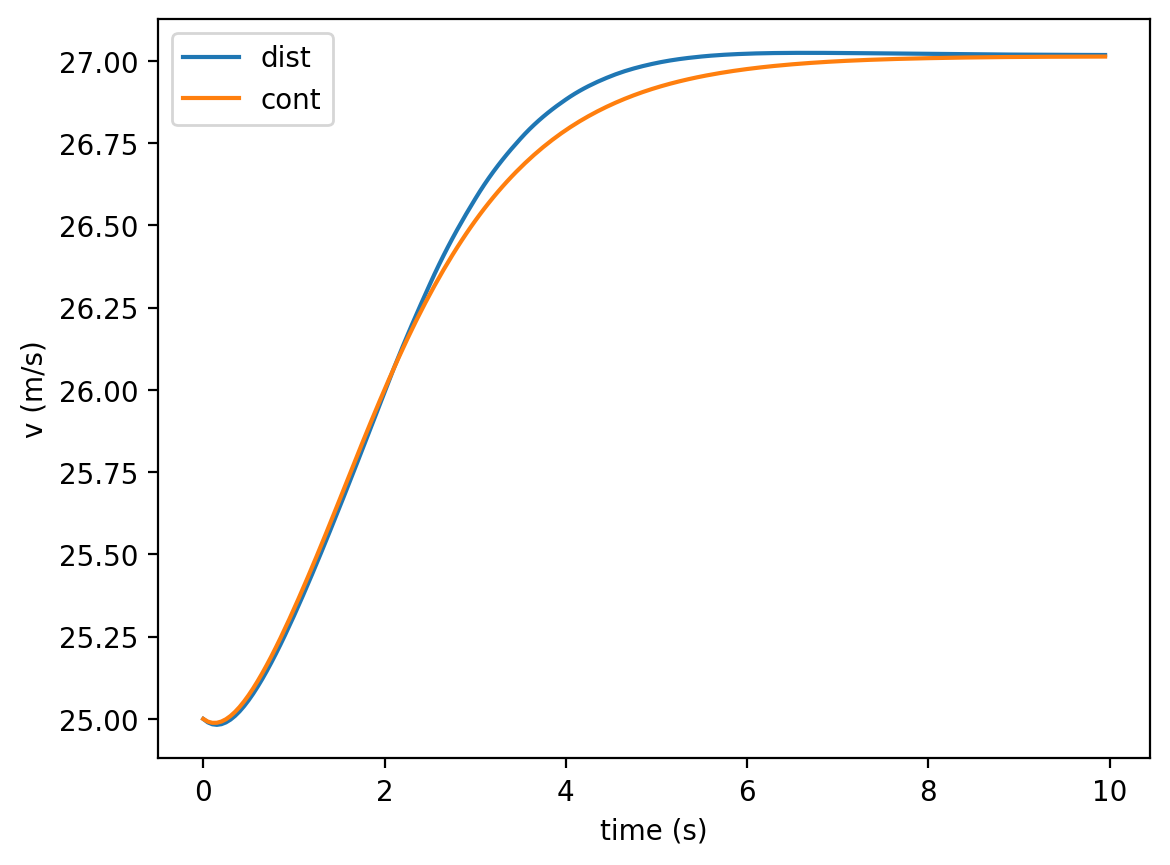

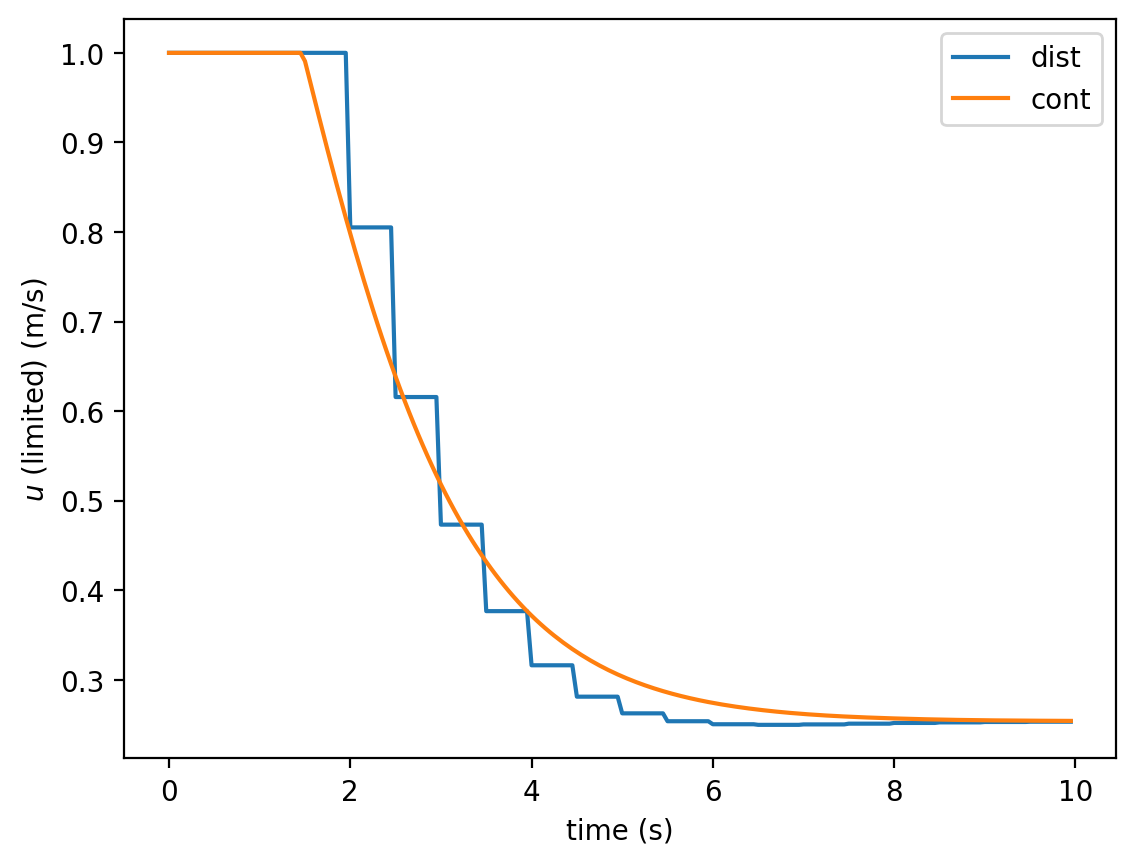

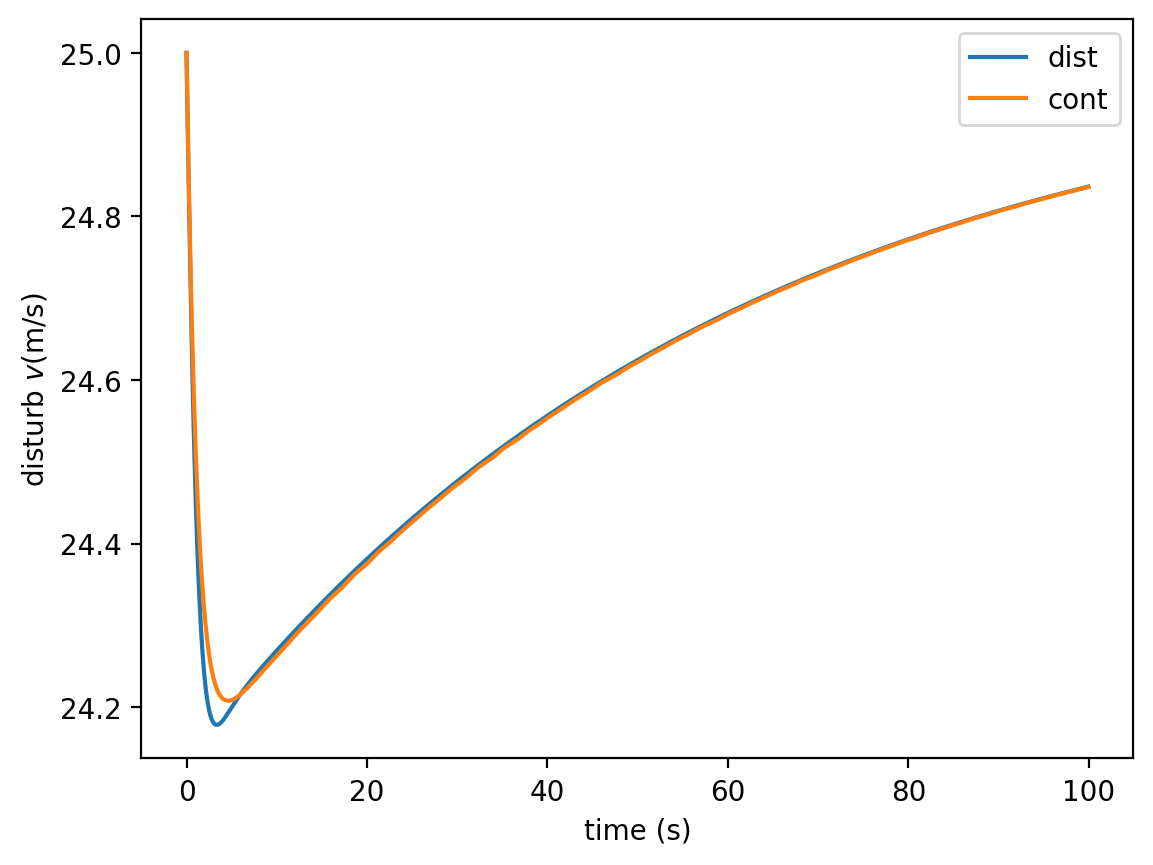

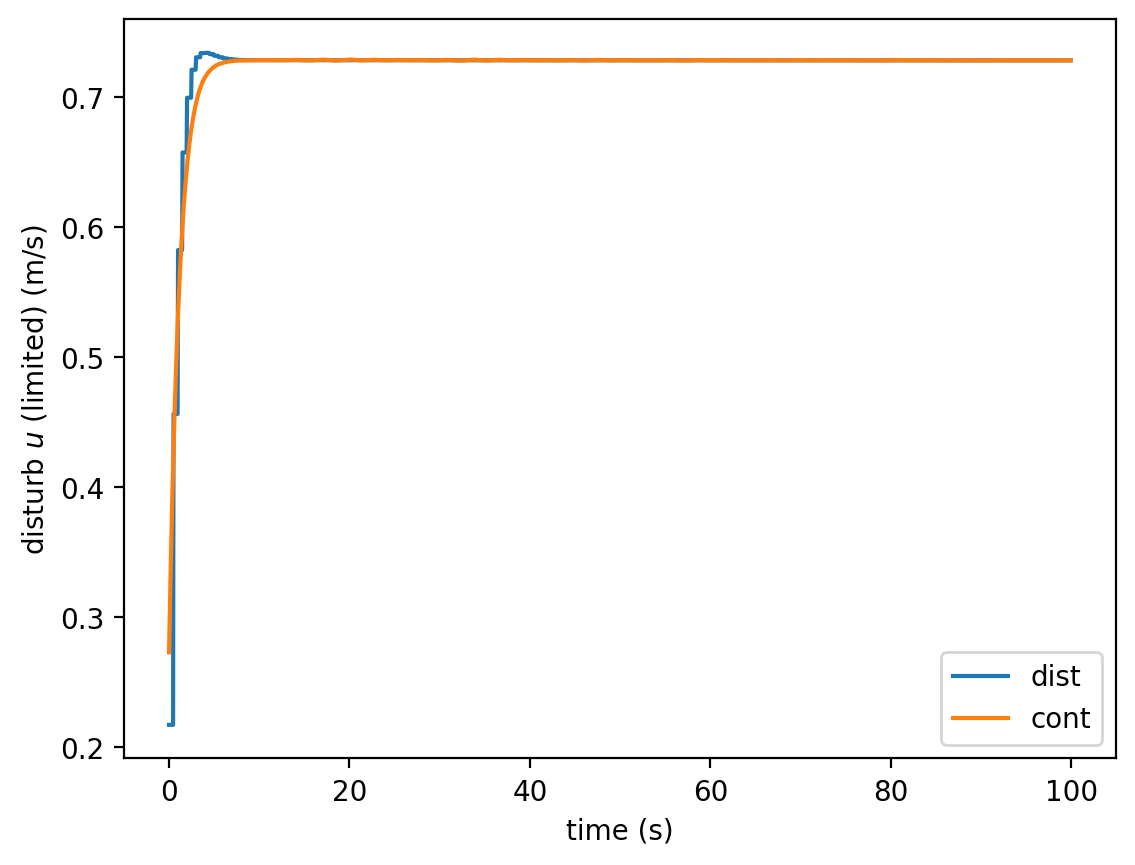

In [36]:
vref = 27
time = np.arange(0, 10, simulation_dt)

tdist, ydist = ct.input_output_response(sysd_yr, time, vref)
tcont, ycont = ct.input_output_response(sys_yr, time, vref)

plt.plot(tdist, ydist, label = 'dist')
plt.plot(tcont, ycont, label = 'cont')
plt.xlabel('time (s)')
plt.ylabel('v (m/s)')
plt.legend()

plt.figure()
tdist, udist = ct.input_output_response(sysd_ur, time, vref)
tcont, ucont = ct.input_output_response(sys_ur, time, vref)

plt.plot(tdist, udist, label = 'dist')
plt.plot(tcont, ucont, label = 'cont')
plt.xlabel('time (s)')
plt.ylabel('$u$ (limited) (m/s)');
plt.legend()

# disturbance responses
time2 = np.arange(0, 100, simulation_dt)
disturb = -M * g * np.sin(np.arctan(0.05))
plt.figure()
# the (ycont2,) below extracts first row because this is not a single-in-single-out sys
tdist2, (ydist2,) = ct.input_output_response(sysd_yd, time2, [v0, disturb])
tcont2, (ycont2,) = ct.input_output_response(sys_yd, time2, [v0, disturb])
plt.plot(tdist2, ydist2, label = 'dist')
plt.plot(tcont2, ycont2, label = 'cont')
plt.xlabel('time (s)')
plt.ylabel('disturb $v$(m/s)');
plt.legend()
plt.figure()
tdist2, (udist2,) = ct.input_output_response(sysd_ud, time2, [v0, disturb])
tcont2, (ucont2,) = ct.input_output_response(sys_ud, time2, [v0, disturb])
plt.plot(tdist2, udist2, label = 'dist')
plt.plot(tcont2, ucont2, label = 'cont')
plt.xlabel('time (s)')
plt.ylabel('disturb $u$ (limited) (m/s)');
plt.legend()